<a href="https://colab.research.google.com/github/amadousysada/ecommerce-customer-segmentation/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from collections import defaultdict as default_dict
from sqlite3 import connect
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import numpy as np
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [3]:
folder_path = "/content/drive/MyDrive/data/" # A ajuster selon le chemin où se trouve votre fichier .db

# 1 | Préparation des données

In [4]:
data = pd.read_csv(folder_path + "olist_customer_cleaned_data.csv")
monetary_frequency_outliers_df = pd.read_csv(folder_path + "olist_customer_monetary_frequency_outliers.csv")
monetary_outliers_df = pd.read_csv(folder_path + "olist_customer_monetary_outliers.csv")
frequency_outliers_df = pd.read_csv(folder_path + "olist_customer_frequency_outliers.csv")

In [5]:
data.head()

,customer_unique_id,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,first_purch_at,last_purch_at,last_purch_day_of_week,customer_zip_code_prefix,rfm_segment_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,8,413,5.0,1.0,1.0,2018-05-10 10:56:27,2018-05-10 10:56:27,3,7787,top (Gold)
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,6,411,4.0,1.0,1.0,2018-05-07 11:11:27,2018-05-07 11:11:27,0,6053,risk (bronze)
2,0000f46a3911fa3c0805444483337064,536,1,86.22,4,112,3.0,1.0,1.0,2017-03-10 21:05:03,2017-03-10 21:05:03,4,88115,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4,211,4.0,1.0,1.0,2017-10-12 20:29:41,2017-10-12 20:29:41,3,66812,inactive
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,7,214,5.0,1.0,1.0,2017-11-14 19:45:42,2017-11-14 19:45:42,1,18040,good (silver)


In [6]:
data.describe()

,recency,frequency,monetary,rfm_score,rfm_segment,satisfaction,nbre_items,distinct_products,last_purch_day_of_week,customer_zip_code_prefix
count,84296.000000,84296.0,84296.000000,84296.000000,84296.000000,84296.000000,84296.000000,84296.000000,84296.000000,84296.000000
mean,237.480426,1.0,117.851660,5.832056,263.626281,4.138073,1.114703,1.032172,2.757913,34937.390790
std,152.598946,0.0,76.189564,1.548778,111.706049,1.311104,0.435235,0.199613,1.968543,29816.892629
min,0.000000,1.0,9.590000,3.000000,111.000000,0.000000,1.000000,1.000000,0.000000,1003.000000
25%,114.000000,1.0,59.090000,5.000000,211.000000,4.000000,1.000000,1.000000,1.000000,11070.000000
50%,219.000000,1.0,98.290000,6.000000,311.000000,5.000000,1.000000,1.000000,3.000000,24240.000000
75%,346.000000,1.0,158.200000,7.000000,411.000000,5.000000,1.000000,1.000000,4.000000,58106.000000
max,694.000000,1.0,372.720000,9.000000,414.000000,5.000000,21.000000,7.000000,6.000000,99980.000000


In [7]:
pca_2d_dict =  {}
pca_3d_dict =  {}
tsne_2d = {}
tsne_3d = {}
results = default_dict(dict)

def find_best_k(data):
  """
  Cette fonction permet d'estimer le meilleur k (nombre de cluster optimal) pour un dataset donné.
  data: dataframe
  return: silhouette_scores, dict_kmeans, best_silhouette_k
  """
  silhouette_scores = {}
  inertia_scores = {}
  dict_kmeans = {}

  for k in range(2, 15):
      kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
      cluster_labels = kmeans.predict(data)
      #silhouette_scores[k] = silhouette_score(data, cluster_labels, n_jobs=-1)
      inertia_scores[k] = kmeans.inertia_
      dict_kmeans[k] = kmeans

  #best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
  #print(f"best_k={best_silhouette_k}, best_silhouette_k={silhouette_scores[best_silhouette_k]}")
  return inertia_scores, dict_kmeans


def compute_silhouette_score(data, k_values):
  for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    cluster_labels = kmeans.predict(data)
    silhouette_scores[k] = silhouette_score(data, cluster_labels, n_jobs=-1)
    best_silhouette_k = max(silhouette_scores, key=silhouette_scores.get)
    return silhouette_scores, best_silhouette_k

def plot_silhouette_scores(data, silhouette_scores, best_silhouette_k):
  fig = plt.figure(figsize=(18,5))

  plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker="o", linestyle="-", label="Score de silhouette")
  plt.axvline(x=best_silhouette_k, color="r", linestyle="--", label=f"Meilleur silhouette à k={best_silhouette_k}")
  plt.xlabel("Nombre de clusters (k)")
  plt.xlabel("Nombre de clusters (k)")
  plt.ylabel("Silhouette Score")
  plt.title("Score de silhouette en fonction de k")
  plt.legend()


  visualizer = SilhouetteVisualizer(estimator=KMeans(random_state=42), k=(2, 25))

  visualizer.fit(data)    # Fit the data to the visualizer
  visualizer.poof(ax=axes[1])

  plt.show()

def plot_inertia_scores(inertia_scores):
  fig = plt.figure(figsize=(18,5))

  plt.plot(list(inertia_scores.keys()), list(inertia_scores.values()), marker="o", linestyle="-", label="Inertie")
  #plt.axvline(x=best_silhouette_k, color="r", linestyle="--", label=f"Meilleur silhouette à k={best_silhouette_k}")
  plt.xlabel("Nombre de clusters (k)")
  plt.ylabel("Inertie")
  plt.xlabel("Nombre de clusters (k)")
  plt.title("The Elbow method using Inertia")
  plt.legend()

  plt.show()

def plot_clusters(labels, X_pca_2d=None, X_pca_3d=None, title="Kmeans"):
  # Visualiser les résultats
  fig = plt.figure(figsize=(16, 8))

  cmap = mpl.colormaps.get_cmap('viridis')

  # Visualiser les résultats
  if X_pca_2d is not None:
    ax1 = fig.add_subplot(2,2,1)
    ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax1.set_title(f"{title} Clustering with PCA 2D Visualization")
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')

  if X_pca_3d is not None:
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax.set_title(f"{title} Clustering with PCA 3D Visualization")
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel("PC3")
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)


  '''if X_tsne is not None:
    ax = fig.add_subplot(222, projection='3d')
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with t-SNE 3D Visualization')
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")
    ax.set_zlabel("t-SNE3")

    ax = fig.add_subplot(2,2,4)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    ax.set_title('K-means Clustering with t-SNE 2D Visualization')
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")
  '''

  plt.show()


def get_pca(dim=2, selection='full', df=None):
  """
  dim: int => dimension de la projection
  selection: str => full ou rfm
  df: dataframe => dataframe à utiliser pour la projection
  return: X_pca
  """
  if selection == 'full':
    if dim == 2:
      if pca_2d_dict.get('full') is not None:
        return pca_2d_dict['full']
      pca = PCA(n_components=2)
      X_pca = pca.fit_transform(df)
      pca_2d_dict['full'] = (pca, X_pca)
      return (pca, X_pca)
    elif dim == 3:
      if pca_3d_dict.get('full') is not None:
        return pca_3d_dict['full']
      pca = PCA(n_components=3)
      X_pca = pca.fit_transform(df)
      pca_3d_dict['full'] = (pca, X_pca)
      return (pca, X_pca)
    else:
      raise ValueError("dim doit être 2 ou 3")
  else:
    if dim == 2:
      if pca_2d_dict.get(selection) is not None:
        return pca_2d_dict[selection]
      pca = PCA(n_components=2)
      X_pca = pca.fit_transform(df)
      pca_2d_dict[selection] = (pca, X_pca)
      return (pca, X_pca)
    elif dim == 3:
      if pca_3d_dict.get(selection) is not None:
        return pca_3d_dict[selection]
      pca = PCA(n_components=3)
      X_pca = pca.fit_transform(df)
      pca_3d_dict[selection] = (pca, X_pca)
      return (pca, X_pca)
    else:
      raise ValueError("dim doit être 2 ou 3")

# 2 | prévalence de la loyauté des clients

La segmentation RFM (Récence, Fréquence, Montant) nous a permis d’évaluer la fidélité des clients et de les classer en quatre segments distincts :  

1. **Gold (Clients Premium)** : Ces clients affichent des scores RFM élevés, indiquant une activité récente, une fréquence d’achat soutenue et des montants de dépenses significatifs. Ils représentent les clients les plus précieux.  

2. **Silver (Clients Loyaux)** : Ce segment regroupe les clients ayant un score élevé sur au moins un des trois critères (récence, fréquence ou montant). Ils sont engagés mais pourraient être encore plus valorisés.  

3. **Bronze (Clients à Risque)** : Ces clients montrent des signes de désengagement, avec une baisse de la fréquence ou de la récence de leurs achats. Il est essentiel d’anticiper leur attrition en mettant en place des actions ciblées.  

4. **Inactive (Clients Perdus)** : Ce segment comprend les clients inactifs depuis une période prolongée. Une stratégie de réactivation peut être envisagée pour les inciter à revenir.  

Cette segmentation permet d’optimiser les actions marketing en adaptant les stratégies d’engagement et de rétention en fonction du profil de chaque client.

In [8]:
rfm_counts = data['rfm_segment_loyalty'].value_counts()

fig = px.pie(
    rfm_counts,
    values=rfm_counts.values,
    names=rfm_counts.index,
    title="Distribution des client par segment de Loyalty",
    hole=0
    )
fig.update_traces(textinfo="label+percent", textfont_size=12, rotation=90)
fig.update_layout(showlegend=True, legend_title_text="Segment de Loyalty")
fig.show()

# 3 | Standardisation des données

In [9]:
num_cols = ['recency', 'frequency', 'monetary', 'satisfaction', 'nbre_items', 'distinct_products']
ss = StandardScaler()

In [10]:
X_scaled = pd.DataFrame(ss.fit_transform(data[num_cols]), columns=num_cols)
X_scaled['customer_unique_id'] = data['customer_unique_id']
X_scaled.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,-0.828847,0.0,0.315640,0.657410,-0.263544,-0.161175,0000366f3b9a7992bf8c76cfdf3221e2
1,-0.809187,0.0,-1.189956,-0.105311,-0.263544,-0.161175,0000b849f77a49e4a4ce2b2a4ca5be3f
2,1.956248,0.0,-0.415173,-0.868032,-0.263544,-0.161175,0000f46a3911fa3c0805444483337064
3,0.540764,0.0,-0.974308,-0.105311,-0.263544,-0.161175,0000f6ccb0745a6a4b88665a16c9f078
4,0.324510,0.0,1.037397,0.657410,-0.263544,-0.161175,0004aac84e0df4da2b147fca70cf8255


In [11]:
monetary_frequency_outliers_scaled = pd.DataFrame(ss.fit_transform(monetary_frequency_outliers_df[num_cols]), columns=num_cols)
monetary_frequency_outliers_scaled['customer_unique_id'] = monetary_frequency_outliers_df['customer_unique_id']
monetary_frequency_outliers_scaled.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,0.104930,-0.281527,-0.216863,0.765673,-0.446516,-0.364235,004288347e5e88a27ded2bb23747066c
1,-0.571964,-0.281527,-0.485095,-0.543921,-0.446516,-0.364235,011575986092c30523ecb71ff10cb473
2,-0.123076,-0.281527,-0.443938,0.329142,0.315451,-0.364235,011b4adcd54683b480c4d841250a987f
3,-0.750094,-0.281527,0.054235,0.329142,-0.446516,-0.364235,012452d40dafae4df401bced74cdb490
4,-0.999477,-0.281527,2.006403,-0.543921,-0.446516,-0.364235,012a218df8995d3ec3bb221828360c86


In [12]:
monetary_outliers_scaled = pd.DataFrame(ss.fit_transform(monetary_outliers_df[num_cols]), columns=num_cols)
monetary_outliers_scaled['customer_unique_id'] = monetary_outliers_df.customer_unique_id
monetary_outliers_scaled.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,-0.356338,0.0,-0.610628,-1.980663,0.481022,2.245196,00053a61a98854899e70ed204dd4bafe
1,-1.235814,0.0,-0.385865,0.708185,-0.378338,-0.227087,003162bf0351f47a1a247992b8b9b42d
2,-1.113843,0.0,-0.599411,0.708185,-0.378338,-0.227087,0033f4a2887e07e25aa1204d482f41ba
3,-0.824964,0.0,-0.367642,0.708185,0.481022,-0.227087,0035029989e6fc5cf030918a5f9f2037
4,-0.150913,0.0,-0.563635,-0.636239,-0.378338,-0.227087,0037aa56b017c105c3a9d47af71fff98


In [13]:
frequency_outliers_scaled = pd.DataFrame(ss.fit_transform(frequency_outliers_df[num_cols]), columns=num_cols)
frequency_outliers_scaled['customer_unique_id'] = frequency_outliers_df.customer_unique_id
frequency_outliers_scaled.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,-0.973949,-0.085149,-0.068689,-0.244421,-0.322663,-0.206551,00a39521eb40f7012db50455bf083460
1,1.978278,-0.085149,0.012850,-0.244421,-0.322663,-0.206551,00cc12a6d8b578b8ebd21ea4e2ae8b27
2,-0.401028,-0.085149,-1.393768,-1.205198,-0.322663,-0.206551,01886ef98f995e4f2dd75a1d04c97397
3,-0.090977,-0.085149,1.094694,0.716357,1.784256,3.457640,01a22e2079ea71e17313b88e5811e54a
4,0.569567,-0.085149,-0.671802,0.716357,-0.322663,-0.206551,027803eb28cc01fbdf5da72b109fabee


In [14]:
rfm_feats = ['recency', 'frequency', 'monetary']
full_feats = ['recency', 'frequency', 'monetary', 'satisfaction', 'nbre_items', 'distinct_products']

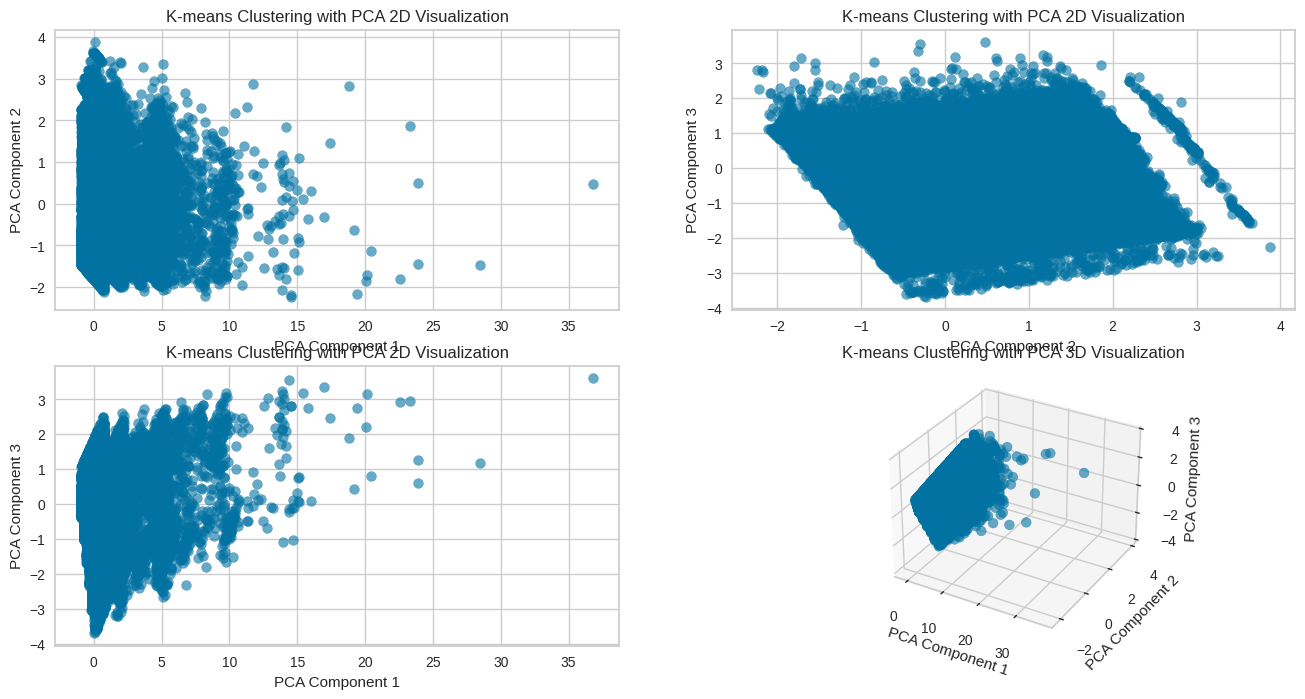

In [15]:
fig = plt.figure(figsize=(16, 8))

cmap = mpl.colormaps.get_cmap('coolwarm')

X_pca = PCA(n_components=3).fit_transform(X_scaled[full_feats])

ax1 = fig.add_subplot(2,2,1)
ax1.scatter(X_pca[:, 0], X_pca[:, 1], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')

ax1 = fig.add_subplot(2,2,2)
ax1.scatter(X_pca[:, 1], X_pca[:, 2], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 2')
ax1.set_ylabel('PCA Component 3')

ax1 = fig.add_subplot(2,2,3)
ax1.scatter(X_pca[:, 0], X_pca[:, 2], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 2D Visualization')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 3')

ax1 = fig.add_subplot(2,2,4, projection='3d')
ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=50, alpha=0.6)
ax1.set_title('K-means Clustering with PCA 3D Visualization')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')

plt.show()

# 4 | K-Means Clustering

In [16]:
kmeans_data = X_scaled.copy()
kmeans_data.head()

,recency,frequency,monetary,satisfaction,nbre_items,distinct_products,customer_unique_id
0,-0.828847,0.0,0.315640,0.657410,-0.263544,-0.161175,0000366f3b9a7992bf8c76cfdf3221e2
1,-0.809187,0.0,-1.189956,-0.105311,-0.263544,-0.161175,0000b849f77a49e4a4ce2b2a4ca5be3f
2,1.956248,0.0,-0.415173,-0.868032,-0.263544,-0.161175,0000f46a3911fa3c0805444483337064
3,0.540764,0.0,-0.974308,-0.105311,-0.263544,-0.161175,0000f6ccb0745a6a4b88665a16c9f078
4,0.324510,0.0,1.037397,0.657410,-0.263544,-0.161175,0004aac84e0df4da2b147fca70cf8255


## | 4.1 clustering avec les features rfm seulement

In [17]:
first_selection_df = kmeans_data[rfm_feats]

In [18]:
%%time
# Appliquer PCA pour réduire à 2 et 3 dimensions
pca_2d, X_pca_2d = get_pca(dim=2, selection='rfm', df=first_selection_df)
pca_3d, X_pca_3d = get_pca(dim=3, selection='rfm', df=first_selection_df)

print(f"Les deux dimensions capture {sum(pca_2d.explained_variance_ratio_ * 100)}")
print("-----"*9)
print(f"Les trois dimensions capture {sum(pca_3d.explained_variance_ratio_ * 100)}")
print("\n")

Les deux dimensions capture 100.0
---------------------------------------------
Les trois dimensions capture 100.0


CPU times: user 13.4 ms, sys: 1.97 ms, total: 15.4 ms
Wall time: 12.2 ms


### 4.1.1 | recherche du k optimal

In [19]:
%%time
inertia_scores, dict_kmeans = find_best_k(first_selection_df.values)

CPU times: user 4.16 s, sys: 35.1 ms, total: 4.19 s
Wall time: 2.51 s


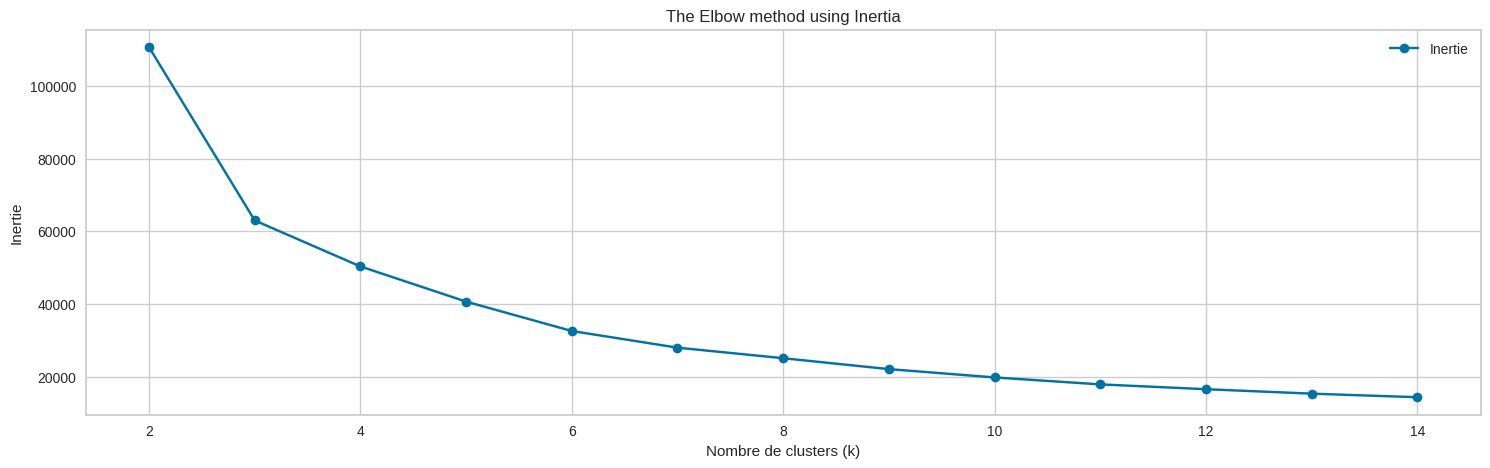

In [20]:
plot_inertia_scores(inertia_scores=inertia_scores)

D'après la courbe d'inertie, on observe un coude marqué autour de k = 4 ou k = 5.
À partir de ce point, l'inertie diminue moins rapidement, ce qui indique un bon équilibre entre la compacité des clusters et leur nombre. Nous pouvons donc choisir k = 4 ou k = 5 comme valeur optimale pour notre modèle de clustering.

Pour déterminer si k=4 ou k=5 est le meilleur choix, nous allons utiliser l'approche suivante:

- La visualisation des clusters : nous afficherons les clusters pour voir si la séparation est nette.

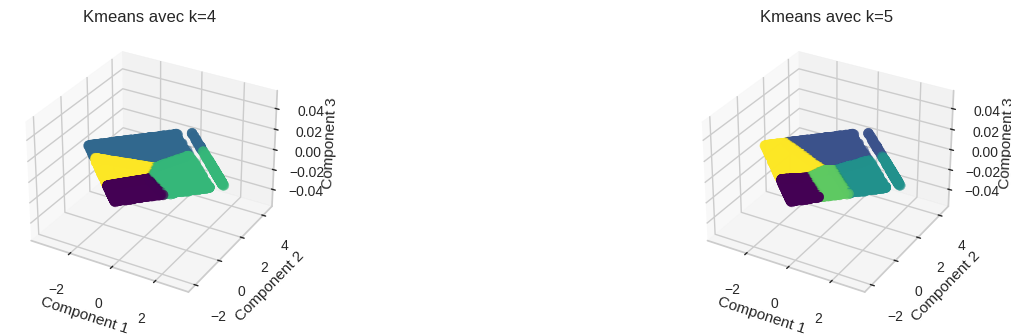

CPU times: user 9.72 s, sys: 72.6 ms, total: 9.79 s
Wall time: 9.51 s


In [21]:
%%time
fig = plt.figure(figsize=(16, 8))

cmap = mpl.colormaps.get_cmap('viridis')

kmeans_4 = KMeans(n_clusters=4, random_state=42).fit(first_selection_df)
labels_4 = kmeans_4.labels_

kmeans_5 = KMeans(n_clusters=5, random_state=42).fit(first_selection_df)
labels_5 = kmeans_5.labels_

ax = fig.add_subplot(221, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_4, cmap='viridis', s=50, alpha=0.6)
ax.set_title("Kmeans avec k=4")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel("Component 3")

ax = fig.add_subplot(222, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_5, cmap='viridis', s=50, alpha=0.6)
ax.set_title("Kmeans avec k=5")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel("Component 3")

plt.show()

En comparant les visualisations :  
- **k = 4** : Les clusters sont bien définis, mais certaines structures internes restent regroupées.  
- **k = 5** : Un cluster supplémentaire permet une séparation plus fine des données sans trop complexifier le modèle.  

Puisque la répartition des points ne change pas radicalement et que l’ajout du 5ᵉ cluster affine la segmentation, **k = 5** semble être le meilleur choix pour capturer plus de nuances dans les données.

### 4.1.2 | Kmean avec  k=5

In [22]:
%%time
kmeans = KMeans(n_clusters=5, random_state=42).fit(first_selection_df)
labels = kmeans.labels_
first_selection_df.loc[:, "cluster"] = labels

CPU times: user 211 ms, sys: 1.85 ms, total: 212 ms
Wall time: 118 ms


<timed exec>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



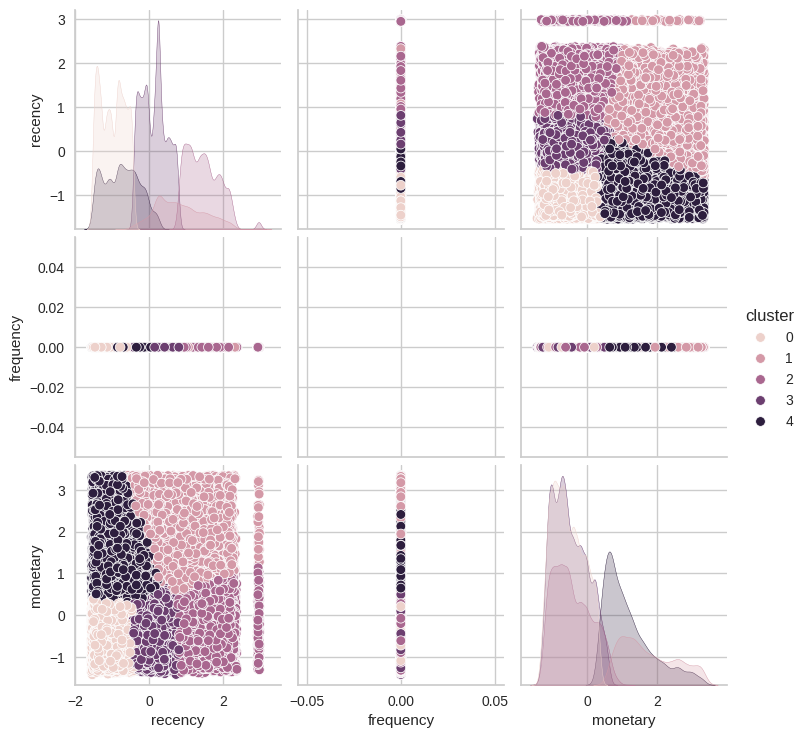

In [23]:
sns.pairplot(first_selection_df, hue="cluster")
plt.show()

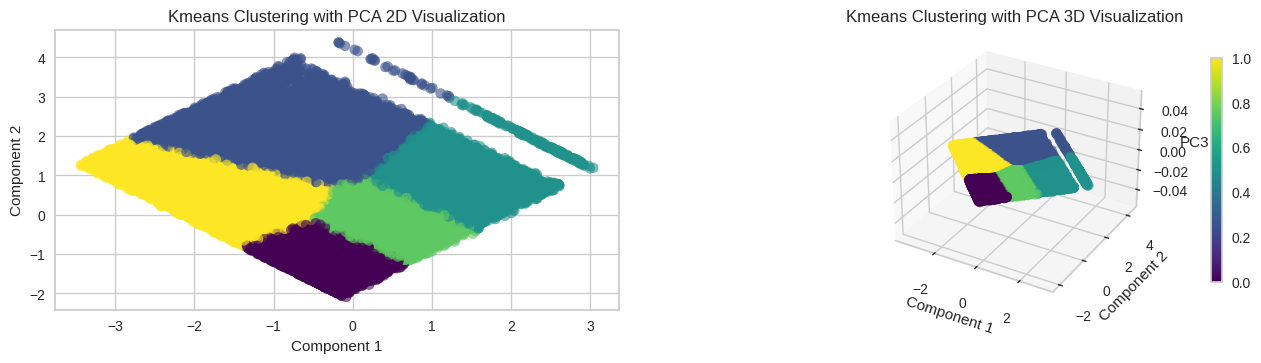

In [24]:
# Visualiser les résultats en 3D et 2D
plot_clusters(labels, X_pca_2d, X_pca_3d)

## | 4.2 clustering avec l'ensemble des features

In [25]:
%%time
X = kmeans_data.copy()
# Appliquer PCA pour réduire à 2 et 3 dimensions
pca_2d, X_pca_2d = get_pca(dim=2, selection='full', df=X[full_feats])
pca_3d, X_pca_3d = get_pca(dim=3, selection='full', df=X[full_feats])

print(f"Les deux dimensions capture {sum(pca_2d.explained_variance_ratio_ * 100)}")
print("-----"*9)
print(f"Les trois dimensions capture {sum(pca_3d.explained_variance_ratio_ * 100)}")
print("\n")

Les deux dimensions capture 52.60426268276003
---------------------------------------------
Les trois dimensions capture 71.80046697596066


CPU times: user 36.3 ms, sys: 26 µs, total: 36.3 ms
Wall time: 27.7 ms


### 4.2.1 | recherche du k optimal

In [26]:
%%time
inertia_scores, dict_kmeans = find_best_k(X[full_feats].values)

CPU times: user 3.77 s, sys: 19.9 ms, total: 3.79 s
Wall time: 2.07 s


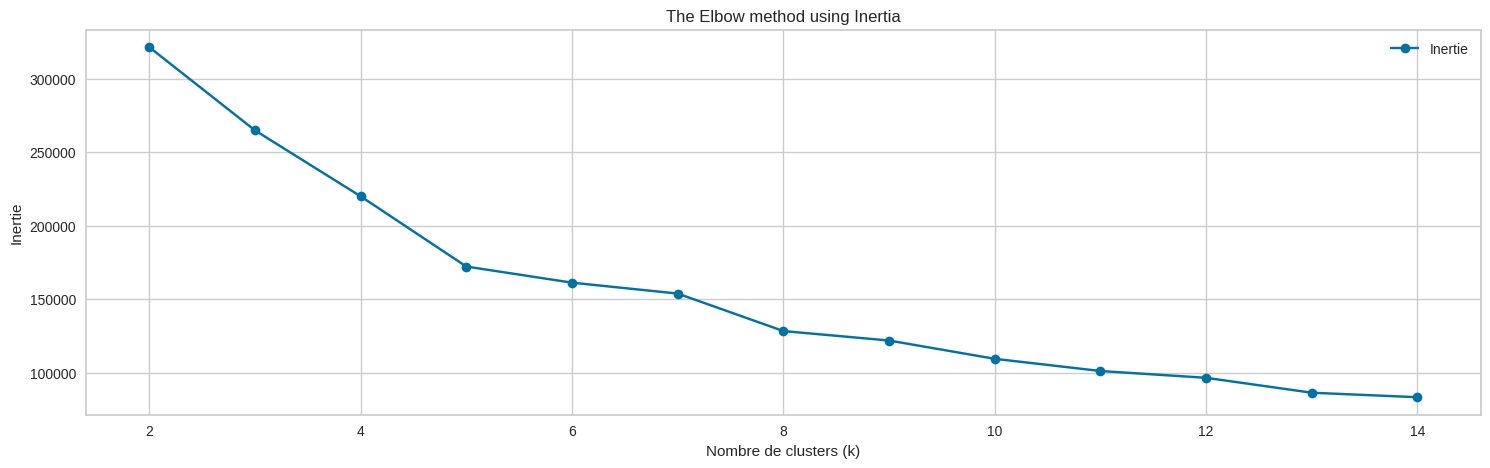

In [27]:
plot_inertia_scores(inertia_scores=inertia_scores)

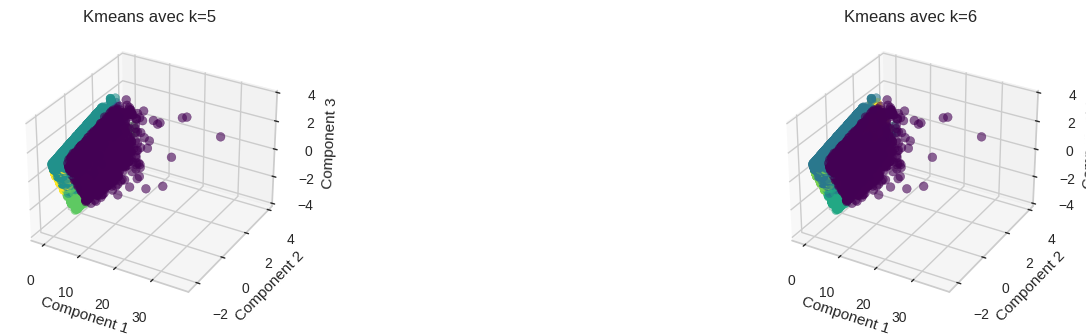

CPU times: user 9.85 s, sys: 88.3 ms, total: 9.94 s
Wall time: 9.63 s


In [28]:
%%time
fig = plt.figure(figsize=(18, 8))

cmap = mpl.colormaps.get_cmap('viridis')

kmeans_5 = KMeans(n_clusters=5, random_state=52).fit(X[full_feats])
labels_5 = kmeans_5.labels_

kmeans_6 = KMeans(n_clusters=6, random_state=52).fit(X[full_feats])
labels_6 = kmeans_6.labels_

ax = fig.add_subplot(221, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_5, cmap='viridis', s=40, alpha=0.6)
ax.set_title("Kmeans avec k=5")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel("Component 3")

ax = fig.add_subplot(222, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=labels_6, cmap='viridis', s=40, alpha=0.6)
ax.set_title("Kmeans avec k=6")
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel("Component 3")

plt.show()

En comparant les visualisations :  
- Avec 𝑘=5: Les clusters semblent bien définis

### 4.2.2 | Kmean avec  k=5

In [29]:
%%time
kmeans_2 = KMeans(n_clusters=5, random_state=42).fit(X[full_feats])
labels_2 = kmeans_2.labels_

X_ = X[full_feats].copy()
X_["cluster"] = labels

CPU times: user 186 ms, sys: 959 µs, total: 187 ms
Wall time: 122 ms


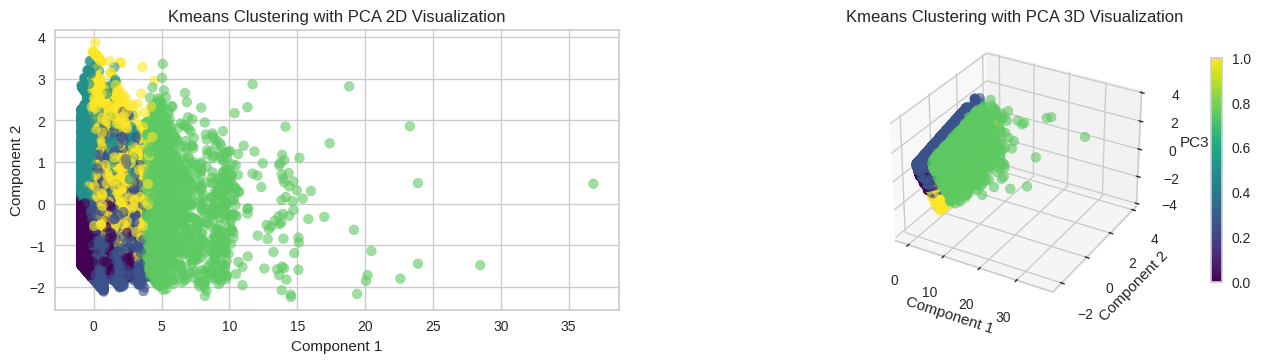

In [30]:
plot_clusters(labels_2, X_pca_2d, X_pca_3d)

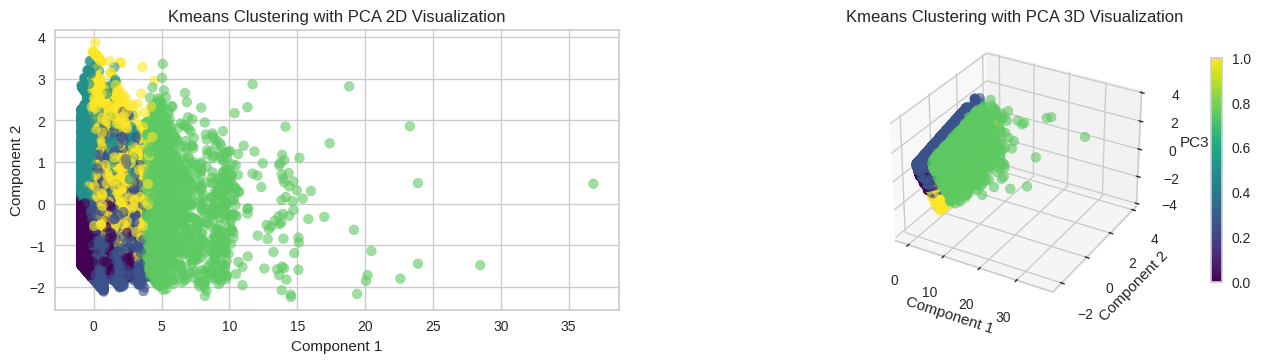

In [31]:
plot_clusters(labels_2, X_pca_2d, X_pca_3d)

**Conclusion**: Le nombre de clusters reste identique malgré l'ajout de nouvelles variables, cela signifie que la structure globale des données est déjà bien capturée par les variables RFM. Cependant on observe que les clusters sont mieux separés (inertie-inter class plus grand) avec les données rfm.

Pour la suite de notre modélisation nous allons uniquement considérés les données rfm.

In [32]:
%%time
results["kmeans"] = {
    'Number of clusters': 5,
    'Silhouette score': silhouette_score(first_selection_df, labels, metric='euclidean'),
    'Davies-Bouldin score': davies_bouldin_score(first_selection_df, labels),
    }

CPU times: user 1min 23s, sys: 21.7 s, total: 1min 45s
Wall time: 1min 23s


In [33]:
results

defaultdict(dict,
            {'kmeans': {'Number of clusters': 5,
              'Silhouette score': np.float64(0.6022020479708685),
              'Davies-Bouldin score': np.float64(0.624713276958848)}})

In [34]:
# Utilisation des radars plots pour une meilleure intrepretation des clusters

# 5 | DBscan Clustering

Le dbscan(density-based spatial clustering of applications with noise) est un algorithme non supervisé trés simple.

Il definit les clusters en se basant sur la densité des points.

L'algorithme peut etre divisé en 4 phase:

1. Pour chaque observation (point) on regarde le nombre de points à au plus une distance epsilon e (On appelle e: e voisinage de l'observation)
2. Si une observation compte au moins un certain nobmre de voisins y compris elle-meme, elle est considerée comme une **observation coeur** -> Observation à haute densité.
3. Toutes les observations au voisinage d'une observation coeur appartiennent au meme cluster.
4. Toute observation qui n'est pas une observation coeur dans son voisinage est considérée comme une anomalie.

Concernant le choix du epsilon, notre approche consiste alors à utiliser la librairie **NearestNeighbors** de sckit-learn  pour fixer le epsilon optimal.

In [35]:
dbscan_data= X_scaled[rfm_feats].copy()

## 5.1 | recherche du epsilon(e) optimal

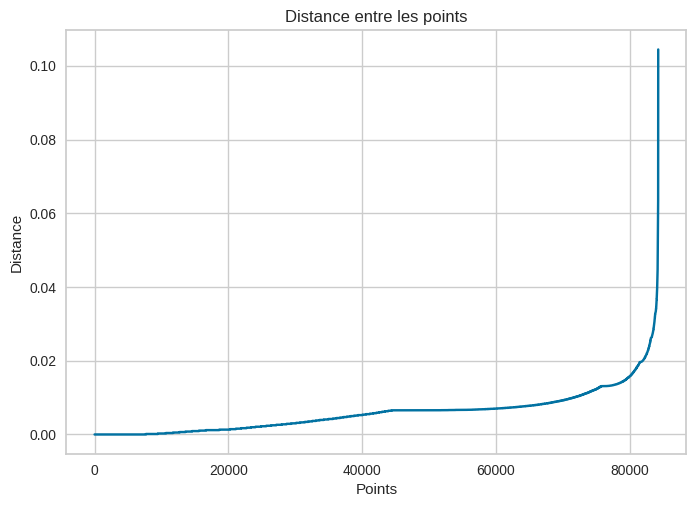

CPU times: user 522 ms, sys: 10.4 ms, total: 532 ms
Wall time: 557 ms


In [36]:
%%time
nn = NearestNeighbors(n_neighbors=2)
nn_fit = nn.fit(dbscan_data)
distances, indices = nn_fit.kneighbors(dbscan_data)
distances = distances[:,1]
distances = np.sort(distances, axis=0)
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.title("Distance entre les points")
plt.show()

In [37]:
mask = distances < 0.1
new_arr = distances[mask]
print(len(new_arr))
display(distances[mask])

84295


array([0.        , 0.        , 0.        , ..., 0.0895141 , 0.09421316,
       0.09837113])

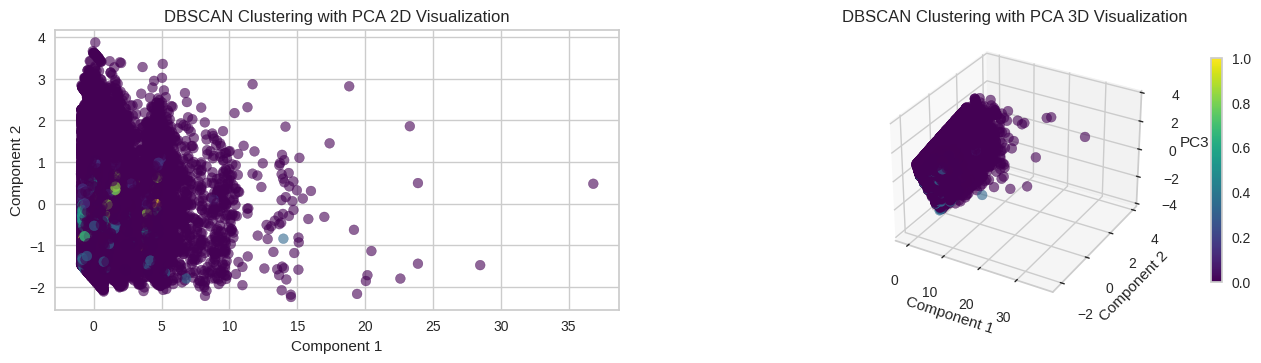

CPU times: user 9.6 s, sys: 262 ms, total: 9.86 s
Wall time: 9.72 s


In [38]:
%%time
dbscan = DBSCAN(eps=0.1, min_samples=600)
labels_dbscan = dbscan.fit_predict(dbscan_data)
plot_clusters(labels_dbscan, X_pca_2d, X_pca_3d, "DBSCAN")

In [39]:
np.unique(labels_dbscan)

array([-1,  0,  1,  2,  3,  4,  5])

In [40]:
%%time
results["DBSCAN"] = {
    'Number of clusters': 6,
    'Silhouette score': silhouette_score(dbscan_data, labels_dbscan, metric='euclidean'),
    'Davies-Bouldin score': davies_bouldin_score(dbscan_data, labels_dbscan),
    }

CPU times: user 1min 31s, sys: 21.7 s, total: 1min 52s
Wall time: 1min 30s


# 6 | Hierarchical Agglomerative Clustering (HAC)

In [55]:
hac_data= X_scaled[rfm_feats].sample(20000, random_state=42)

In [56]:
%%time
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
Z = linkage(hac_data, method='ward')

CPU times: user 22.7 s, sys: 3.45 s, total: 26.2 s
Wall time: 26.2 s


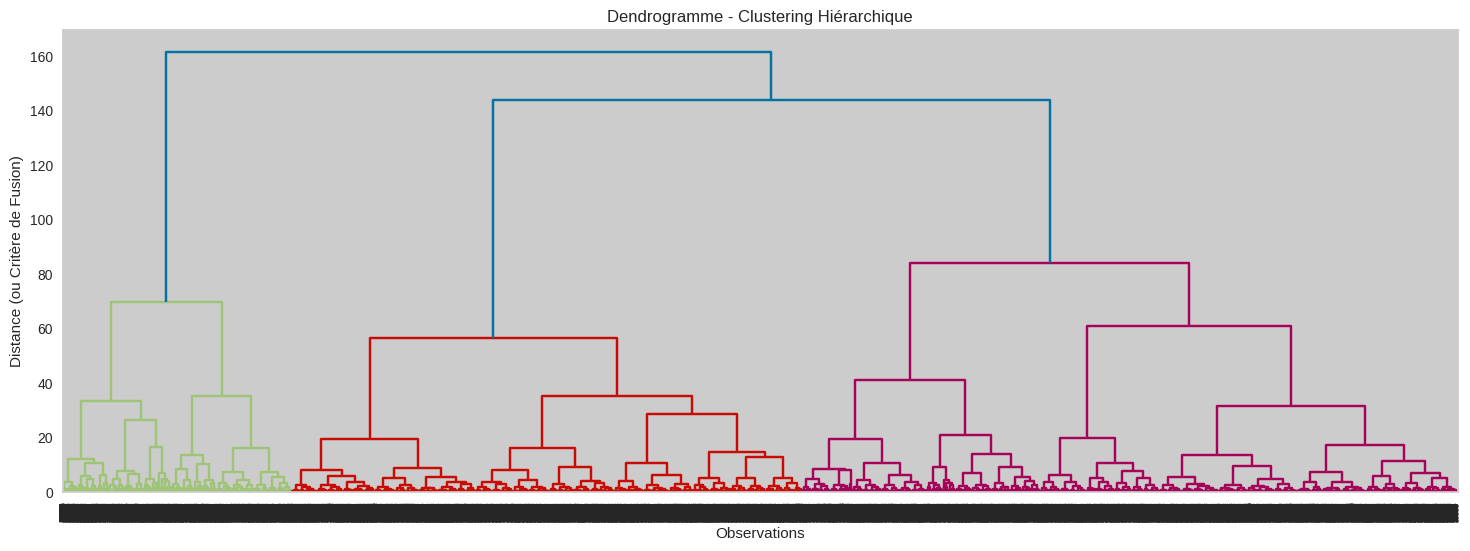

In [57]:
plt.figure(figsize=(18, 6))
dendrogram(Z)
plt.title('Dendrogramme - Clustering Hiérarchique')
plt.xlabel('Observations')
plt.ylabel('Distance (ou Critère de Fusion)')
plt.show()

### 6.1 | Recherche du k optimal

Pour determiner le meilleur k nous allons construire une hierarchie pour k=20 à k=80 en evaluant le score Calinski and Harabasz Index (CH Index). Le meilleur k correspond à celui ayant un score plus elévé.

L'indice de Calinski-Harabasz (CH) pour un nombre de clusters \(K\) est défini par :

$$
CH(K) = \frac{B(K)/(K-1)}{W(K)/(n-K)}
$$

Où :
- \(B(K)\) représente la dispersion entre les clusters,
- \(W(K)\) représente la dispersion intra-cluster,
- \(K\) est le nombre de clusters,
- \(n\) est le nombre total de points.

In [61]:
%%time
calinski_harabasz_scores = {}
for k in range(2, 10):
    cluster = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    cluster.fit_predict(hac_data)
    score = calinski_harabasz_score(hac_data, cluster.labels_)
    calinski_harabasz_scores[k] = score

CPU times: user 3min 2s, sys: 12.1 s, total: 3min 14s
Wall time: 3min 14s


In [62]:
values = np.array(list(calinski_harabasz_scores.values()))
idx = np.argmax(values)
best_hac_k = list(calinski_harabasz_scores.keys())[idx]
print(f"Le score max est de: {values[idx]}")
print(f"Le k optimal est de: {best_hac_k}")

Le score max est de: 14063.203590621884
Le k optimal est de: 7


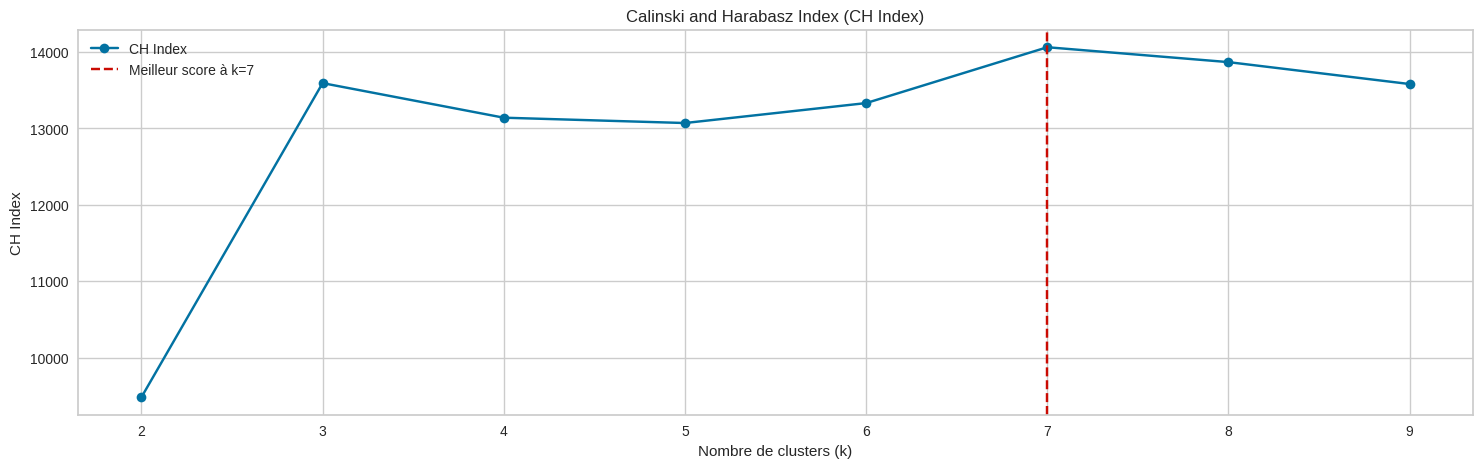

In [66]:
fig = plt.figure(figsize=(18,5))

plt.plot(list(calinski_harabasz_scores.keys()), list(calinski_harabasz_scores.values()), marker="o", linestyle="-", label="CH Index")
plt.axvline(x=best_hac_k, color="r", linestyle="--", label=f"Meilleur score à k={best_hac_k}")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("CH Index")
plt.xlabel("Nombre de clusters (k)")
plt.title("Calinski and Harabasz Index (CH Index)")
plt.legend()

plt.show()

In [98]:
ls = fcluster(Z, t=7, criterion='maxclust')
display(ls)

array([7, 1, 3, ..., 7, 2, 2], dtype=int32)

In [100]:
%%time
hac = AgglomerativeClustering(n_clusters=7, metric='euclidean', linkage='ward')
labels_hac = hac.fit_predict(hac_data)
display(labels_hac)

array([2, 4, 6, ..., 2, 3, 3])

CPU times: user 22.1 s, sys: 1.67 s, total: 23.8 s
Wall time: 23.8 s


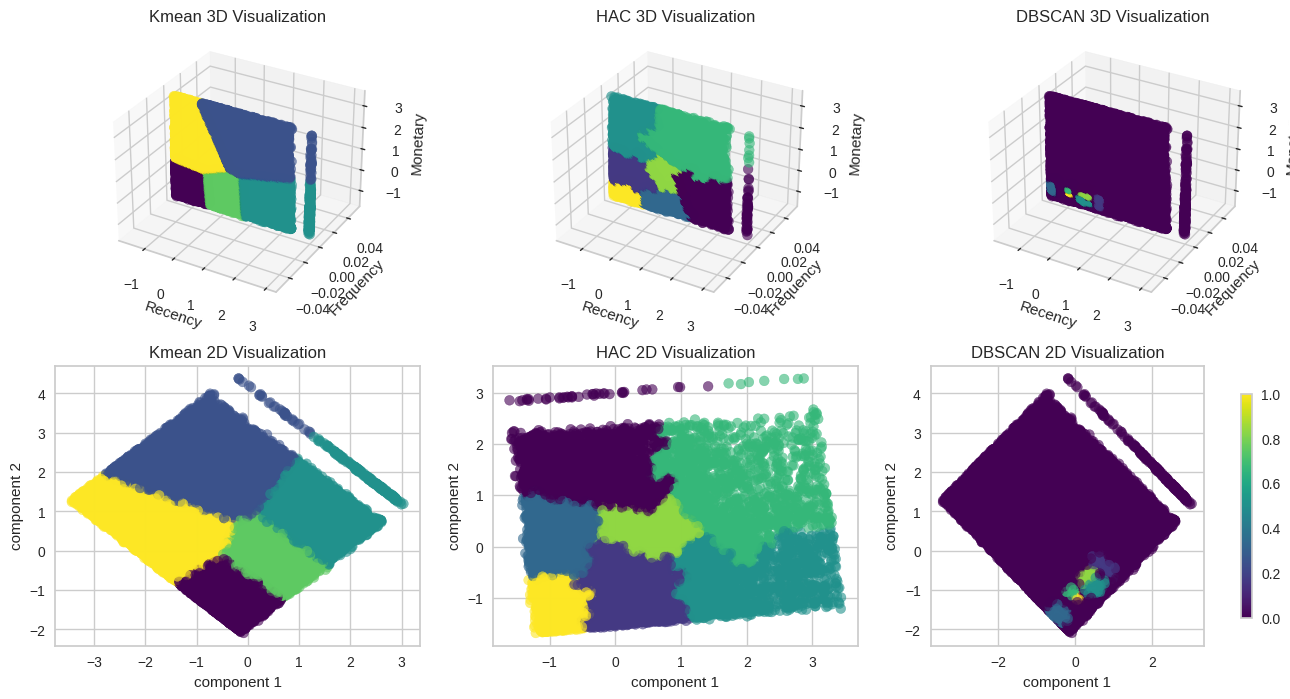

In [105]:
fig = plt.figure(figsize=(16, 8))

cmap = mpl.colormaps.get_cmap('viridis')

ax = fig.add_subplot(231, projection='3d')
ax.scatter(kmeans_data.recency, kmeans_data.frequency, kmeans_data.monetary, c=labels, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"Kmean 3D Visualization")
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel("Monetary")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans_data[['recency', 'frequency', 'monetary']])
ax = fig.add_subplot(2,3,4)
ax.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"Kmean 2D Visualization")
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')

ax = fig.add_subplot(232, projection='3d')
ax.scatter(hac_data.recency, hac_data.frequency, hac_data.monetary, c=labels_hac, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"HAC 3D Visualization")
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel("Monetary")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(hac_data[['recency', 'frequency', 'monetary']])
ax = fig.add_subplot(2,3,5)
ax.scatter(X_pca[:,0], X_pca[:,1], c=labels_hac, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"HAC 2D Visualization")
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')

ax = fig.add_subplot(233, projection='3d')
ax.scatter(dbscan_data.recency, dbscan_data.frequency, dbscan_data.monetary, c=labels_dbscan, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"DBSCAN 3D Visualization")
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel("Monetary")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(dbscan_data[['recency', 'frequency', 'monetary']])
ax = fig.add_subplot(2,3,6)
ax.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='viridis', s=50, alpha=0.6)
ax.set_title(f"DBSCAN 2D Visualization")
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.1)
plt.show()

In [53]:
%%time
results["HAC"] = {
    'Number of clusters': 4,
    'Silhouette score': silhouette_score(hac_data, labels_hac, metric='euclidean'),
    'Davies-Bouldin score': davies_bouldin_score(hac_data, labels_hac),
    }

CPU times: user 1.85 s, sys: 606 ms, total: 2.46 s
Wall time: 1.91 s


In [54]:
pd.DataFrame(results).T

,Number of clusters,Silhouette score,Davies-Bouldin score
kmeans,5.0,0.602202,0.624713
DBSCAN,6.0,-0.203734,1.258937
HAC,4.0,0.395920,0.882052


# 7 | Interpretation des clusters Kmeans

In [ ]:
df = X_scaled.copy()
df.loc[:,'cluster'] = labels

In [ ]:
## 7.1 | Statistique des clusters

In [ ]:
df.groupby('cluster').agg({
    'recency': ['mean', 'min', 'max'],
    'frequency': ['mean', 'min', 'max'],
    'monetary': ['mean', 'min', 'max']}).T

1. Cluster 0:


*   Recency (mean = 0.93)
→ Valeur positive : ces clients sont, en moyenne, moins récents (ils ont effectué leur dernier achat il y a relativement longtemps).
*  Frequency (mean = -0.16)
→ Valeur faible et constante, suggérant une faible fréquence d'achat.
* Monetary (mean = -0.23) → Dépenses légèrement inférieures à la moyenne.
* Satisfaction (mean = 0.35) → Satisfaction plutôt positive malgré une activité faible.

Ces clients semblent moins actifs (achat ancien et rare) et dépensent moins, mais ils restent globalement satisfaits. Ils pourraient être des clients « dormants » ou des clients à reconquérir.



2. Cluster 1:


*   Recency (mean ≈ -0.11)
→ Légèrement en dessous de la moyenne : ces clients ont effectué leur dernier achat récemment.

* Frequency (mean = 5.16)
→ Fréquence d'achat très élevée (valeur nettement supérieure aux autres clusters).
* Monetary (mean = 1.56)
→ Dépenses au-dessus de la moyenne.
* Satisfaction (mean ≈ 0.04)
→ Satisfaction proche de la moyenne.

Ce groupe regroupe des clients dont l'activité (récence, fréquence et montant) est plutôt moyenne, mais qui sont fortement insatisfaits. Ce sont des clients à risque, qui pourraient rapidement se détourner de l'offre s'ils ne voient pas d'amélioration.


3. Cluster 2

*   Recency (mean ≈ -0.11)
→ Légèrement en dessous de la moyenne : ces clients ont effectué leur dernier achat récemment.
* Frequency (mean = 5.16)
→ Fréquence d'achat très élevée (valeur nettement supérieure aux autres clusters).
* Monetary (mean = 1.56)
→ Dépenses au-dessus de la moyenne.
* Satisfaction (mean ≈ 0.04)
→ Satisfaction proche de la moyenne.

Il s'agit clairement de clients fidèles et actifs qui achètent très fréquemment et dépensent davantage. Leur satisfaction est moyenne, ce qui laisse une marge d'amélioration pour fidéliser encore plus ce segment stratégique.

4. Cluster 3

*  Recency (mean ≈ -0.02)
→ Récence proche de la moyenne.
* Frequency (mean ≈ 0.06)
→ Fréquence d'achat modérée (bien inférieure à celle du cluster 2).
* Monetary (mean = 4.72)
→ Dépenses très élevées, ce qui suggère que ces clients réalisent des achats importants.
* Satisfaction (mean ≈ -0.10)
→ Satisfaction autour de la moyenne.

Ce cluster regroupe des clients à haute valeur : ils n’achètent pas forcément très fréquemment, mais leurs achats sont conséquents en termes de montant. Ils constituent un segment à fort potentiel de revenu, méritant une attention particulière pour maintenir leur niveau de dépense.

In [ ]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=df, x='cluster', y='recency', hue='cluster')
plt.show()

In [ ]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=df, x='cluster', y='frequency', hue='cluster')
plt.show()

In [ ]:
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
sns.boxplot(data=df, x='cluster', y='monetary', hue='cluster')
plt.show()

In [ ]:
cluster_counts = df['cluster'].value_counts()
#df["MonetaryValue per 100 pounds"] = df["MonetaryValue"] / 100.00
#feature_means = df.groupby('ClusterLabel')[['Recency', 'Frequency', 'MonetaryValue per 100 pounds']].mean()
feature_means = df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean()

fig, ax1 = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette='Set2', marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()
